In [1]:
# IMPORTING THE REQUIRED LIBRARIES:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import os
import cv2
import skimage

import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline 

# Ignore harmless warnings:

import warnings
warnings.filterwarnings("ignore")
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

import platform
print(torch.__version__)
print(platform.python_version())


1.8.1
3.6.10


In [2]:
torch.cuda.get_device_name(1)

'TITAN X (Pascal)'

In [3]:
# LOADING DATA: 30000 MOST COMMON ENGLISH WORDS

top_30000_words = pd.read_csv('30k.txt', delimiter = '\t', header = None)

words = []
sample_length = len(top_30000_words)

for i in range(sample_length):
    words.append(top_30000_words.loc[i][0])

total_length = len(words)

In [4]:
# FINDING PROBLEMATIC WORDS

huge_words = 0

for i in range(30000):
    if type(words[i]) == float:
        print(i)
        
    elif len(words[i]) > 15:
        words[i] = 'gavab'
        huge_words += 1
        #print(i)

words[2577] = 'null'
words[12819] = 'nan'
print(huge_words)

2577
12819
35


In [5]:
# DEFINING TRAINING, VALIDATION AND TEST SETS

#train_set = words[0:28000]
#val_set = words[28000:29000] 
test_set = words[29000:30000] 
test2 = words[20000:21000]

MAX_LENGTH = max(len(list(word)) for word in words) # length of the longest word within our sample

print(MAX_LENGTH)
#print(test_set)

15


In [6]:
# ONE HOT ENCODING OF THE ALPHABET (+ START, END & PAD)

letters = ['START', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k',
          'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'END', 'PAD']


def letter_to_vector(letter):
    vector = torch.zeros(1, 1, len(letters))
    for i in range(len(letters)):
        if letters[i] == letter:
            vector[0, 0, i] = 1.
    return(vector)


print(letter_to_vector('PAD'))

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]])


In [7]:
# GETTING PATCH TENSOR FOR EACH WORD (PATCH, COLOR CHANNEL, HEIGHT, WIDTH)

def patch_gen(word, n_patches, patch_height, patch_width, stepsize):
    
    image = 255 * np.ones(shape = [height, width], dtype = np.uint8)
    image = cv2.putText(image, text = word, org = (5, 30),
        fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.62, color = (0, 0, 0),
        thickness = 1, lineType = cv2.LINE_AA)
    image = transforms.ToPILImage()(image) # np.ndarray to PIL.Image.Image
    patches_tensor = torch.empty(n_patches, color_channels, patch_height, patch_width)
    
    for p in range(n_patches):
        
        patch = transforms.functional.crop(image, 0, 0 + p * stepsize, patch_height, patch_width) # cropping of the image into patches
        patch = transforms.ToTensor()(patch) # torch.Tensor of the patch (normalized)
        #patch = skimage.util.random_noise(patch, mode='s&p') # we set some random noise to the image
        #patch = torch.from_numpy(patch) # conversion to pytorch tensor again
        patch = 1. - patch # it will work better if we have white text over black background
        patch = patch.view(1, 1, patch_height, patch_width) # CNN_model expects a 4-dimensional tensor (1 dimension for batch)
        patch = patch.type(torch.FloatTensor) # conversion to float
        patch = patch.cuda(1) # set to cuda
        patches_tensor[p, 0, :, :] = patch
        patches_tensor = patches_tensor.cuda(1)
        
    return patches_tensor,

In [47]:
# SETTING IMAGE AND SLIDING WINDOW (PATCH) PARAMETERS

height = 48
width = 192
patch_height = 48
patch_width = 10
stepsize = 2
color_channels = 1
n_patches = int((width - patch_width)/stepsize + 1) 

In [9]:
# GETTING TUPLE (TENSOR WITH PATCHES, LABEL) FOR EACH WORD OF A GIVEN SET:

def complete_set(which_set):
    
    complete_set = []
    
    for word in which_set:
        
        complete_set.append((patch_gen(word, n_patches, patch_height, patch_width, stepsize), word))
        
    return complete_set

In [10]:
# TUPLE OF (RANK-4 TENSOR [PATCH, CHANNEL, HEIGHT, WIDTH], LABEL) FOR EVERY WORD IN EVERY SET

#comp_train_set = complete_set(which_set = train_set)
#comp_val_set = complete_set(which_set = val_set)
comp_test_set = complete_set(which_set = test_set)
comp_test2 = complete_set(which_set = test2)

In [11]:
# LOADING DATA AND SETS IN BATCHES

torch.manual_seed(123)

batch_size = 16

#train_loader = DataLoader(comp_train_set, batch_size = batch_size, shuffle = True)
#val_loader = DataLoader(comp_val_set, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(comp_test_set, batch_size = batch_size, shuffle = False)
test2_loader = DataLoader(comp_test2, batch_size = batch_size, shuffle = False)

In [12]:
# GETTING ONE HOT TENSOR OF THE TARGET WORD

    # one hot tensor of the input batch of words for the Decoder:
    # 1 dim for position within batch, 1 dim for position of the letter in the fixed sequence (MAX_LENGTH + START + END),
    # 1 final dim specifying letter (output_size = 26 + START and END tokens)
    # torch.zeros() ensures that we always have PAD token vectors in case our target word is not MAX_LENGTH long
    # WARNING: only works if label contains 2 words or more (it is OK as long as we are doing batching)
    
def get_one_hot_target(label, batch, seq_len, output_size):
    
    one_hot_target = torch.zeros(batch, seq_len, output_size) 

    for j in range(batch): # for each word of the batch

        length = len(list(label[j])) # we compute the number of letters

        one_hot_target[j, 0, :] = letter_to_vector('START') # the first letter of every word will always be the START

        for k in range(0, length): # now for each letter of the target word

            target_letter = list(label[j])[k] # picks the 'k' target letter 
            one_hot_target[j, k + 1, :] = letter_to_vector(target_letter) # adds that one hot target letter to our global tensor

        one_hot_target[j, length + 1, :] = letter_to_vector('END') # we put END after the last letter of the word
        
        for m in range(length + 2, seq_len):
            
            one_hot_target[j, m, :] = letter_to_vector('PAD') # padding until the end of the sequence
        
    return one_hot_target        

In [13]:
# CONVERTS THE LOGSOFTMAX DECODER OUTPUT DURING EVALUATION TO THE CORRESPONDING ONE-HOT LETTER

def one_hot_conversion(decoder_output, output_size):
    
    one_hot_output_letter = torch.zeros(1, 1, output_size).cuda(1)
    index = torch.argmax(decoder_output, dim = 2).item()
    one_hot_output_letter[0, 0, index] = 1.
    
    return one_hot_output_letter

In [14]:
# DEFINING MODEL AND ARCHITECTURE

# CONVOLUTIONAL NEURAL NETWORK:

class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1, 2) # padding???
        self.conv2 = nn.Conv2d(20, 50, 5, 1, 2)
        self.fc1 = nn.Linear(12*2*50, 1024)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 12*2*50) # -1 para no tener que determinar aquí el tamaño del batch (se ajusta, podemos variarlo)
        X = F.relu(self.fc1(X))

        return X 

In [15]:
# ENCODER:

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first = True)

    def forward(self, input, hidden, batch, seq_len):
        
        output = input.view(batch, seq_len, input_size)
        output, hidden = self.lstm(output, hidden)
        return output, hidden

    def initHidden(self, batch):
        return (torch.zeros(1, batch, self.hidden_size, device=device),
                torch.zeros(1, batch, self.hidden_size, device=device))

In [16]:
# DECODER:

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(output_size, hidden_size, batch_first = True)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 2) 
        # dim = 2 porque esta última dimensión es la correspondiente a output_size, que es sobre
        # la que queremos hacer el softmax

    def forward(self, input, hidden, batch, seq_len):
        
        output = input.view(batch, seq_len, output_size)
        #output = F.relu(output) # la relu se metía aquí porque en el
        #caso NLP del ejemplo de PyTorch previamente había una capa de embedding
        #No nos hace falta porque nuestro tensor de inputs ya es one-hot
        output, hidden = self.lstm(output, hidden)
        output = self.out(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self, batch):
        return (torch.zeros(1, batch, self.hidden_size, device=device),
               torch.zeros(1, batch, self.hidden_size, device=device))

In [17]:
torch.manual_seed(123)

input_size = 1024
hidden_size = 256
output_size = 29

CNN_model = ConvolutionalNetwork().cuda(1)
CNN_optimizer = torch.optim.Adam(CNN_model.parameters(), lr = 0.001)

Encoder_model = EncoderRNN(input_size = input_size, hidden_size = hidden_size).cuda(1)
Encoder_optimizer = optim.SGD(Encoder_model.parameters(), lr = 0.001)

Decoder_model = DecoderRNN(hidden_size = hidden_size, output_size = output_size).cuda(1)
Decoder_optimizer = optim.SGD(Decoder_model.parameters(), lr = 0.001)

#criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()

In [18]:
CNN_model.load_state_dict(torch.load('CNN_model_30000_words_TF_PAD.pt'))
CNN_model.eval()

Encoder_model.load_state_dict(torch.load('Encoder_model_30000_words_TF_PAD.pt'))
Encoder_model.eval()

Decoder_model.load_state_dict(torch.load('Decoder_model_30000_words_TF_PAD.pt'))
Decoder_model.eval()

DecoderRNN(
  (lstm): LSTM(29, 256, batch_first=True)
  (out): Linear(in_features=256, out_features=29, bias=True)
  (softmax): LogSoftmax(dim=2)
)

In [19]:
with torch.no_grad():
    total_model_word = []
    for t, (image_test, label_test) in enumerate(test_loader):

        t += 1
        test_batch = len(label_test)
        
        encoder_hidden_test = Encoder_model.initHidden(batch = test_batch)
        
        image_cnn_test = image_test.view(-1, color_channels, patch_height, patch_width).cuda(1)
        encoder_input_test = CNN_model(image_cnn_test)
        _, encoder_hidden_test = Encoder_model(encoder_input_test, encoder_hidden_test, batch = test_batch, seq_len = n_patches)
        
        for j in range(test_batch):
           
            decoder_input_test = letter_to_vector('START').cuda(1) # We initialize the first Decoder input as the START token

            decoder_hidden_test = (encoder_hidden_test[0][0, j, :].view(1, 1, hidden_size), # We take the last hidden state of the Encoder 
                                   encoder_hidden_test[1][0, j, :].view(1, 1, hidden_size)) # for each image/word (j) within the batch 
            # This would be the first hidden state of the Decoder for image/word (j)

            for d in range(MAX_LENGTH + 2):
                
                decoder_output_test, decoder_hidden_test = Decoder_model(decoder_input_test, decoder_hidden_test, 
                                                                         batch = 1, seq_len = 1)
                
                output_letter = one_hot_conversion(decoder_output_test, output_size = output_size)
                decoder_input_test = output_letter
                
                if d == 0:
                    
                    output_word = output_letter
                    
                else:
                    
                    output_word = torch.cat((output_word, output_letter), dim = 1).cuda(1)
                
                
                END_condition = torch.equal(output_letter, letter_to_vector('END').cuda(1))
                
                if  END_condition == True:
                    
                    break
            
            output_word = torch.argmax(output_word, dim=2)
            output_word = output_word.view(output_word.numel()) # view as a rank-1 tensor
            
            model_word = []


            for item in output_word:
                model_word.append(letters[item])

            model_word = ''.join(model_word[:-1])
            #print(model_word)
            total_model_word.append(model_word)
      
    print(test_set) 
print(total_model_word)

['liberalisation', 'ornate', 'utilise', 'midwife', 'arturo', 'appellee', 'granules', 'uniformed', 'gavab', 'rollout', 'snug', 'homegrown', 'datamonitor', 'reinforces', 'coveted', 'dirham', 'leahy', 'myc', 'prohibitions', 'esophageal', 'moulded', 'deceived', 'kira', 'convict', 'approximations', 'forzieri', 'intermediates', 'kgs', 'albumin', 'grantees', 'nai', 'tossing', 'loveland', 'regularity', 'maloney', 'criticised', 'sativa', 'lawfully', 'paramedic', 'trademarked', 'edgewood', 'goethe', 'stressing', 'slade', 'potable', 'limpopo', 'intensities', 'oncogene', 'dumas', 'antidepressant', 'jester', 'notifies', 'recount', 'ballpark', 'powys', 'orca', 'mascara', 'proline', 'dearest', 'molina', 'nema', 'nook', 'wipers', 'snoopy', 'informationen', 'commensurate', 'esf', 'riverdale', 'schiller', 'bowler', 'unleash', 'juelz', 'bls', 'noarch', 'koss', 'captioned', 'paq', 'wiser', 'gallant', 'summarizing', 'ucsd', 'disbelief', 'gleason', 'gon', 'baritone', 'unqualified', 'cautioned', 'recollectio

In [20]:
acc = 0

test_length = len(test_set)
for i in range(test_length):
        
    if total_model_word[i] == test_set[i]:

        acc += 1
            
print(acc)

685


In [30]:
acc_vector = []

for i in range(test_length):
        
    if total_model_word[i] == test_set[i]:

        acc_vector.append(1)
        
    else:
        
        acc_vector.append(0)
            
print(acc_vector)

[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 

In [34]:
len_vector = []

for i in range(test_length):
    
    len_vector.append(len(test_set[i]))
    
print(len_vector)

[14, 6, 7, 7, 6, 8, 8, 9, 5, 7, 4, 9, 11, 10, 7, 6, 5, 3, 12, 10, 7, 8, 4, 7, 14, 8, 13, 3, 7, 8, 3, 7, 8, 10, 7, 10, 6, 8, 9, 11, 8, 6, 9, 5, 7, 7, 11, 8, 5, 14, 6, 8, 7, 8, 5, 4, 7, 7, 7, 6, 4, 4, 6, 6, 13, 12, 3, 9, 8, 6, 7, 5, 3, 6, 4, 9, 3, 5, 7, 11, 4, 9, 7, 3, 8, 11, 9, 12, 11, 9, 12, 6, 8, 9, 6, 6, 11, 8, 9, 7, 10, 11, 9, 5, 7, 4, 6, 11, 8, 4, 9, 7, 6, 9, 12, 3, 4, 6, 8, 10, 8, 9, 4, 14, 4, 3, 5, 7, 6, 9, 11, 11, 8, 11, 3, 9, 5, 9, 12, 8, 7, 7, 6, 5, 5, 3, 6, 6, 7, 11, 9, 10, 6, 9, 3, 6, 3, 7, 4, 6, 5, 7, 11, 11, 7, 7, 13, 3, 8, 6, 12, 8, 7, 5, 6, 2, 4, 9, 5, 3, 10, 9, 6, 4, 6, 5, 6, 4, 8, 9, 7, 9, 3, 6, 10, 5, 9, 6, 4, 4, 8, 6, 4, 7, 8, 6, 3, 10, 5, 7, 2, 7, 7, 10, 13, 4, 6, 4, 3, 8, 3, 13, 10, 3, 6, 14, 8, 9, 7, 5, 4, 3, 5, 6, 6, 9, 5, 9, 3, 8, 12, 4, 7, 9, 8, 11, 3, 8, 15, 5, 5, 7, 4, 4, 10, 7, 10, 3, 6, 4, 5, 8, 3, 8, 7, 7, 5, 7, 5, 10, 13, 3, 6, 9, 8, 8, 6, 3, 4, 9, 10, 7, 6, 2, 6, 4, 6, 8, 11, 10, 5, 6, 6, 6, 3, 7, 7, 9, 8, 4, 5, 7, 8, 5, 8, 4, 9, 4, 5, 11, 2, 8, 5, 12, 4

[12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 7, 0, 2, 1, 0, 0, 0, 5, 0, 0, 0, 0, 4, 3, 3, 0, 4, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 3, 2, 0, 0, 0, 0, 0, 0, 4, 0, 6, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 3, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 0, 0, 0, 5, 0, 7, 4, 6, 5, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 3, 0, 3, 0, 0, 5, 2, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 2, 2, 3, 0, 0, 0, 0, 0, 0, 0, 6, 0, 4, 0, 0, 1, 0, 0, 4, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 5, 1, 0, 8, 1, 0, 0, 6, 3, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 1, 2, 4, 3, 0, 0, 0, 0, 3, 0, 10, 0, 0, 1, 7, 0, 3, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 6, 0, 4, 5, 0, 3, 0, 2, 10, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 7, 5, 0, 0, 0, 3, 0, 0, 0, 0, 5, 4, 0, 0, 0, 0, 0, 0, 0, 5, 6, 0, 0, 0, 0, 0, 2, 0, 5, 3, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 7, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 5, 0, 0, 

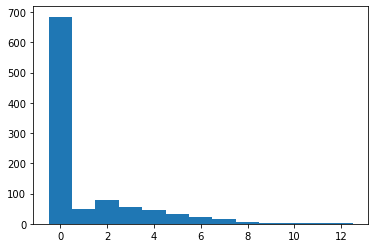

In [22]:
WER_model = []

for i in range(test_length):
    
    WER = 0
    model_length = len(total_model_word[i])
    target_length = len(test_set[i])
    
    smaller = min(model_length, target_length)
    bigger = max(model_length, target_length)
    
    WER += bigger - smaller # accounts for insertions and deletions
    
    for j in range(smaller):

        if total_model_word[i][j] != test_set[i][j]: # accounts for substitutions

            WER += 1

    WER_model.append(WER)
    
print(WER_model)

zeros = 0
for i in range(len(WER_model)):
    
    if WER_model[i] == 0:
        zeros += 1
        
print(zeros)

bins = np.linspace(-0.5, 12.5, 14)
plt.hist(WER_model, bins = bins)
plt.show()


In [31]:
data = {'Model set': total_model_word, 'Test set': test_set, 'WER': WER_model, 'Accuracy': acc_vector, 'Length': len_vector}
data = pd.DataFrame(data)
data.head()

,Model set,Test set,WER,Accuracy,Length
0,lieralisationi,liberalisation,12,0,14
1,ornate,ornate,0,1,6
2,utilise,utilise,0,1,7
3,midwife,midwife,0,1,7
4,arturo,arturo,0,1,6


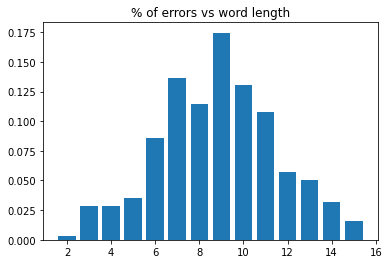

In [43]:
total_error = test_length - acc

errors = []

for i in range(2, MAX_LENGTH + 1):
    
    error = 0
    
    for j in range(test_length):
        
        if (len_vector[j] == i) & (acc_vector[j] == 0):
            
            error += 1
            
    error = error/total_error
    
    errors.append(error)
            
#print(errors)        
x = list(range(2,16)) 
height = errors
plt.bar(x = x, height = height)
plt.title('% of errors vs word length')
plt.show()

In [ ]:
# activar pytorch_estoril (environment) en la terminal y ejecutar tensorboard --host 0.0.0.0 --logdir ./runs
# Tensorboard se ejecutará en un cierto puerto y nos dará el enlace. Habrá que sustituir la IP 0.0.0.0 por la del equipo
# en remoto en la que esté corriendo en el caso de Estoril 212.128.3.86:

In [53]:
# EFFECT OF SALT & PEPPER

image = 255 * np.ones(shape = [height, width], dtype = np.uint8)
image = cv2.putText(image, text = 'methamphetamine', org = (5, 30),
    fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.62, color = (0, 0, 0),
    thickness = 1, lineType = cv2.LINE_AA)
image = transforms.ToPILImage()(image) 
image = transforms.ToTensor()(image)
image = skimage.util.random_noise(image, mode='s&p') # we set some random noise to the image
image = torch.from_numpy(image) # conversion to pytorch tensor again
image = 1. - image
#image = transforms.ToPILImage()(image)
#plt.imshow(image, cmap='gray')
#print(np.max(image))
print(torch.min(image).item())

0.0
